In [45]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from PIL import Image

In [46]:
# patch_size = (25, 25)
patch_size = (15, 15)

In [47]:
sample_h = Image.open('/home/yannik/Bilder/master_thesis/samples/vssil_human.jpg')
sample_t = Image.open('/home/yannik/Bilder/master_thesis/samples/vssil_tiago.jpg')
# sample_t = Image.open('/home/yannik/Bilder/master_thesis/samples/vssil_human2.jpg')

In [48]:
#sample_h = torch.from_numpy(sample_h)
t = ToTensor()
sample_h = t(sample_h).unsqueeze(0).unsqueeze(0)
sample_t = t(sample_t).unsqueeze(0).unsqueeze(0)
#sample_t = torch.from_numpy(sample_t)

In [49]:
print(sample_h.shape)

torch.Size([1, 1, 3, 128, 128])


In [50]:
print(sample_t.shape)

torch.Size([1, 1, 3, 128, 128])


In [51]:
# Manual kpts
h_kpts = torch.empty((1, 1, 4, 2))
h_kpts[0, 0, 0] = torch.tensor([120, 20])  # Orange 
h_kpts[0, 0, 1] = torch.tensor([85, 30])  # Lemon
h_kpts[0, 0, 2] = torch.tensor([35, 60])  # Pear
h_kpts[0, 0, 3] = torch.tensor([55, 40])  # Box

t_kpts = torch.empty((1, 1, 4, 2))
t_kpts[0, 0, 0] = torch.tensor([55, 45])  # Orange 
t_kpts[0, 0, 1] = torch.tensor([85, 30])  # Lemon
t_kpts[0, 0, 2] = torch.tensor([55, 90])  # Pear
t_kpts[0, 0, 3] = torch.tensor([15, 85])  # Box

"""
t_kpts = torch.empty((1, 1, 4, 2))
t_kpts[0, 0, 0] = torch.tensor([125, 25])  # Orange 
t_kpts[0, 0, 1] = torch.tensor([90, 30])  # Lemon
t_kpts[0, 0, 2] = torch.tensor([90, 95])  # Pear
t_kpts[0, 0, 3] = torch.tensor([55, 45])  # Box
"""

'\nt_kpts = torch.empty((1, 1, 4, 2))\nt_kpts[0, 0, 0] = torch.tensor([125, 25])  # Orange \nt_kpts[0, 0, 1] = torch.tensor([90, 30])  # Lemon\nt_kpts[0, 0, 2] = torch.tensor([90, 95])  # Pear\nt_kpts[0, 0, 3] = torch.tensor([55, 45])  # Box\n'

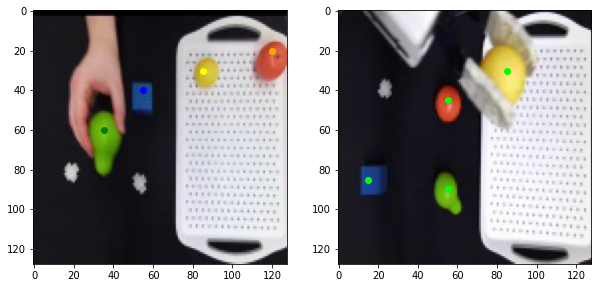

In [52]:
colors = ['orange', 'yellow', 'green', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_h[0, 0].permute(1, 2, 0))
#ax[0].axis('off')
ax[1].imshow(sample_t[0, 0].permute(1, 2, 0))
#ax[1].axis('off')
for k in range(4):
    ax[0].scatter(h_kpts[0, 0, k, 0], h_kpts[0, 0, k, 1], color=colors[k])
    ax[1].scatter(t_kpts[0, 0, k, 0], t_kpts[0, 0, k, 1], color='lime')
plt.show()

In [53]:
from src.utils.kpt_utils import get_image_patches, img_coordinates_2_kpts

h_kpt_coords = img_coordinates_2_kpts(h_kpts, sample_h.shape[-2:])
t_kpt_coords = img_coordinates_2_kpts(t_kpts, sample_h.shape[-2:])

h_patches = get_image_patches(sample_h, h_kpt_coords, patch_size)
t_patches = get_image_patches(sample_t, t_kpt_coords, patch_size)

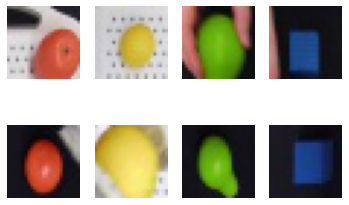

In [54]:
fig, ax = plt.subplots(2, 4)
for k in range(4):
    ax[0, k].imshow(h_patches[0, 0, k].permute(1, 2, 0))
    ax[0, k].axis('off')
    ax[1, k].imshow(t_patches[0, 0, k].permute(1, 2, 0))
    ax[1, k].axis('off')
plt.show()

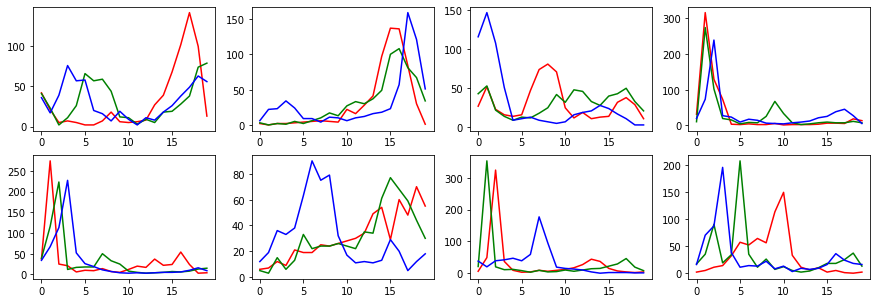

In [55]:
# Color hists
n_bins = 20
h_color_hists = torch.empty((1, 1, 4, 3, n_bins))
t_color_hists = torch.empty((1, 1, 4, 3, n_bins))

for k in range(4):
    for c in range(3):
        h_color_hists[0, 0, k, c] = torch.histc(h_patches[0, 0, k, c], n_bins)
        t_color_hists[0, 0, k, c] = torch.histc(t_patches[0, 0, k, c], n_bins)

        
cs = ['red', 'green', 'blue']
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for k in range(4):
    for c in range(3):
        ax[0, k].plot(h_color_hists[0, 0, k, c], color=cs[c])
        ax[1, k].plot(t_color_hists[0, 0, k, c], color=cs[c])
plt.show()

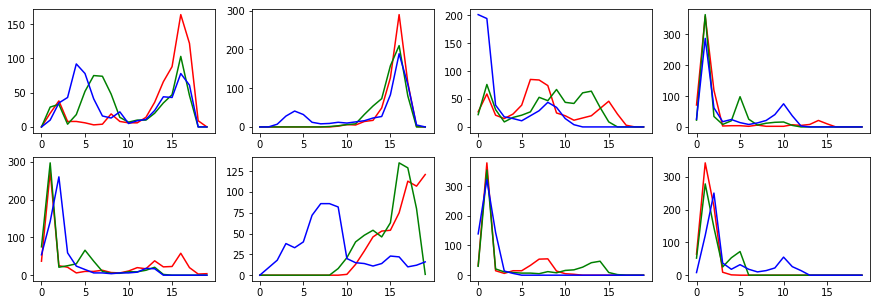

In [56]:
n_bins = 20
h_color_hists = torch.empty((1, 1, 4, 3, n_bins))
t_color_hists = torch.empty((1, 1, 4, 3, n_bins))

cs = ('r', 'g', 'b')
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for k in range(4):
    for i, c in enumerate(cs):
        h_hist = cv2.calcHist([h_patches[0, 0, k].permute(1, 2, 0).cpu().numpy()], [i], mask=None,
                              histSize=[n_bins], ranges=[0, 1])
        t_hist = cv2.calcHist([t_patches[0, 0, k].permute(1, 2, 0).cpu().numpy()], [i], mask=None,
                              histSize=[n_bins], ranges=[0, 1])
        
        h_color_hists[0, 0, k, i] = torch.from_numpy(h_hist).squeeze()
        t_color_hists[0, 0, k, i] = torch.from_numpy(t_hist).squeeze()
        
        ax[0, k].plot(h_hist, color=c)
        ax[1, k].plot(t_hist, color=c)
plt.show()

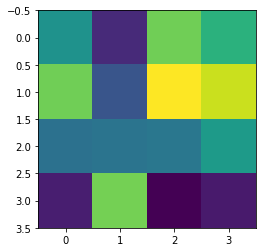

In [57]:
dists = torch.empty([4, 4])
for k in range(4):
    for _k in range(4):
        dists[k, _k] = torch.mean(torch.norm(h_color_hists[0, 0, k] - t_color_hists[0, 0, _k], dim=-1, p=2))
        # dists[k, _k] = torch.sqrt(torch.mean((h_color_hists[0, 0, k]-t_color_hists[0, 0, _k])**2))
        
_ = plt.imshow(dists)

In [58]:
for k in range(4):
    print(torch.argmin(dists[k]))

tensor(1)
tensor(1)
tensor(0)
tensor(2)


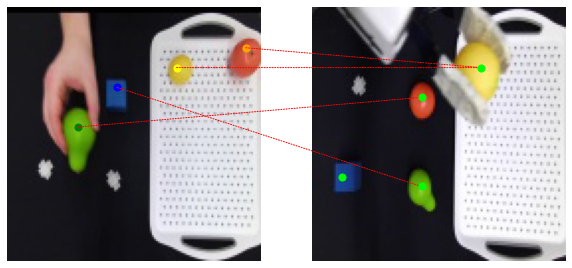

In [59]:
from matplotlib.patches import ConnectionPatch

colors = ['orange', 'yellow', 'green', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_h[0, 0].permute(1, 2, 0), zorder=0)
ax[0].axis('off')
ax[1].imshow(sample_t[0, 0].permute(1, 2, 0), zorder=0)
ax[1].axis('off')
for k in range(4):
    
    # Kpts from target plot with minimal distance
    __k = torch.argmin(dists[k])
    
    con = ConnectionPatch(xyA=h_kpts[0, 0, k], xyB=t_kpts[0, 0, __k], coordsA="data", coordsB="data",
                          axesA=ax[0], axesB=ax[1], color="red", zorder=2, linestyle='dotted')

    ax[1].add_artist(con)
    
    ax[0].scatter(h_kpts[0, 0, k, 0], h_kpts[0, 0, k, 1], color=colors[k], zorder=6, s=50)
    ax[1].scatter(t_kpts[0, 0, k, 0], t_kpts[0, 0, k, 1], color='lime', zorder=5, s=50)
    
    

    
plt.show()

In [60]:
from kornia.filters import sobel

h_patch_grads = sobel(h_patches.squeeze()).unsqueeze(0).unsqueeze(0)
t_patch_grads = sobel(t_patches.squeeze()).unsqueeze(0).unsqueeze(0)

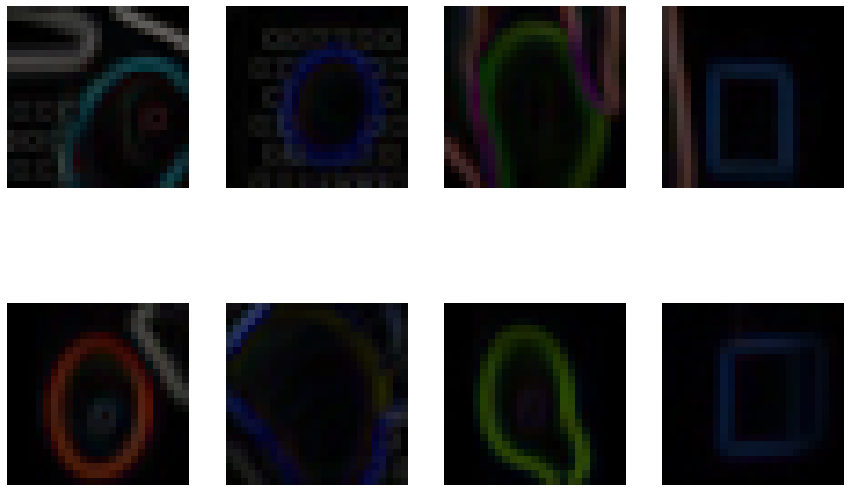

tensor(0.0010)
tensor(0.3800)
tensor(0.0576)


In [61]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
for k in range(4):
    ax[0, k].imshow(h_patch_grads[0, 0, k].permute(1, 2, 0))
    ax[0, k].axis('off')
    ax[1, k].imshow(t_patch_grads[0, 0, k].permute(1, 2, 0))
    ax[1, k].axis('off')
plt.show()

print(h_patch_grads.min())
print(h_patch_grads.max())
print(h_patch_grads.mean())

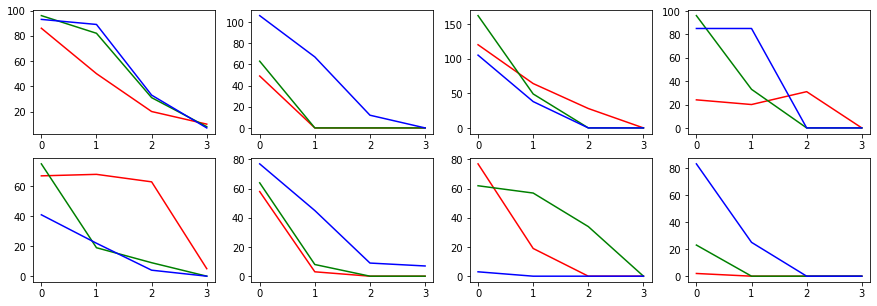

In [62]:
n_bins = 5
#h_color_grad_hists = torch.empty((1, 1, 4, 3, n_bins))
#t_color_grad_hists = torch.empty((1, 1, 4, 3, n_bins))
h_color_grad_hists = torch.empty((1, 1, 4, 3, n_bins - 1))
t_color_grad_hists = torch.empty((1, 1, 4, 3, n_bins - 1))

cs = ('r', 'g', 'b')
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for k in range(4):
    for i, c in enumerate(cs):
        h_hist = cv2.calcHist([h_patch_grads[0, 0, k].permute(1, 2, 0).cpu().numpy()], [i], mask=None,
                              histSize=[n_bins], ranges=[0, 0.4])[1:]
        t_hist = cv2.calcHist([t_patch_grads[0, 0, k].permute(1, 2, 0).cpu().numpy()], [i], mask=None,
                              histSize=[n_bins], ranges=[0, 0.4])[1:]
        
        h_color_grad_hists[0, 0, k, i] = torch.from_numpy(h_hist).squeeze()
        t_color_grad_hists[0, 0, k, i] = torch.from_numpy(t_hist).squeeze()
        
        ax[0, k].plot(h_hist, color=c)
        ax[1, k].plot(t_hist, color=c)
plt.show()

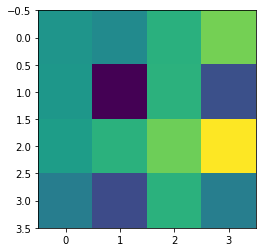

In [63]:
grad_dists = torch.empty([4, 4])
for k in range(4):
    for _k in range(4):
        # grad_dists[k, _k] = torch.mean(torch.norm(h_color_grad_hists[0, 0, k] - t_color_grad_hists[0, 0, _k], dim=-1, p=2))
        grad_dists[k, _k] = torch.sqrt(torch.mean((h_color_grad_hists[0, 0, k]-t_color_grad_hists[0, 0, _k])**2))
        
_ = plt.imshow(grad_dists)

In [64]:
for k in range(4):
    print(torch.argmin(grad_dists[k]))

tensor(1)
tensor(1)
tensor(0)
tensor(1)
